In [14]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial
# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
from Numerics import gradient_first


# Load data

In [15]:
N_y = 384
beta = 1.0
L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]

omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy




tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]
N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])
d_closure_mean = np.copy(closure_mean)
for i in range(N_data):  
    d_closure_mean[i, :] = gradient_first(closure_mean[i, :], dy, bc = "one-sided")
    
# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean

# TODO: clip and filter the data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)
    
    
    
    

    
tau_inv = [0.005, 0.06, 0.2]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]
N_data = len(data_dirs)
closure_mean_test,  q_mean_test, dq_dy_mean_test = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean_test[i, :], q_mean_test[i, :], dq_dy_mean_test[i, :] = load_data(data_dirs[i])
d_closure_mean_test = np.copy(closure_mean_test)
for i in range(N_data):  
    d_closure_mean_test[i, :] = gradient_first(closure_mean_test[i, :], dy, bc = "one-sided")

# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean_test[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean_test[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean_test[i, -chop_l:] = np.linspace(q_mean_test[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean_test[i, 0:chop_l] = np.linspace(beta, dq_dy_mean_test[i,chop_l-1],  chop_l)
    dq_dy_mean_test[i, -chop_l:] = np.linspace(dq_dy_mean_test[i, -chop_l], beta, chop_l)
    
q_mean_abs_test = np.fabs(q_mean_test)  
mu_f_test = closure_mean_test/dq_dy_mean_test

# TODO: clip and filter the data
mu_f_test[mu_f_test >= 0.1 ] = 0.0
mu_f_test[mu_f_test <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f_test[i,:] = scipy.ndimage.gaussian_filter1d(mu_f_test[i,:], 5)
    
    
    

# Visualize data

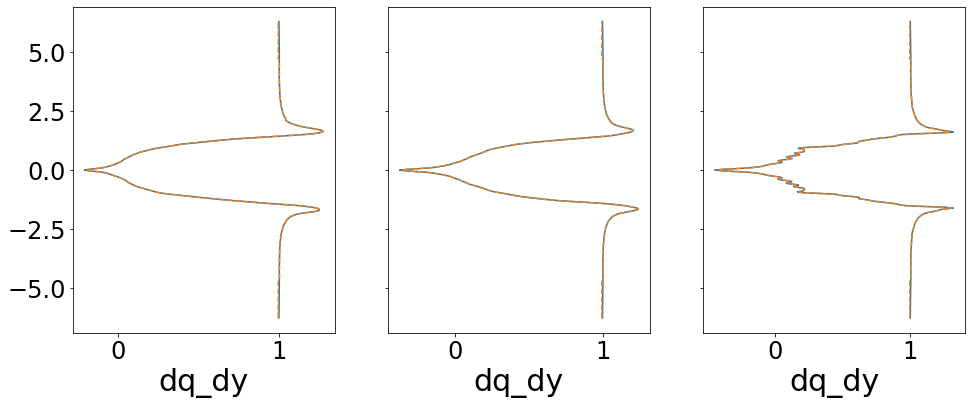

In [16]:
# compare dq_dy_mean vs dq_dy
dq_mean_dy = np.zeros(dq_dy_mean.shape)
for i in range(N_data): 
    dq_mean_dy[i, :] = gradient_first(q_mean[i, :], dy, bc = "one-sided")

fig, ax = plt.subplots(nrows=1, ncols=N_data, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[i].plot(dq_dy_mean[i,:], yy)
    ax[i].plot(dq_mean_dy[i,:], yy, "--")
    ax[i].set_xlabel("dq_dy")
    

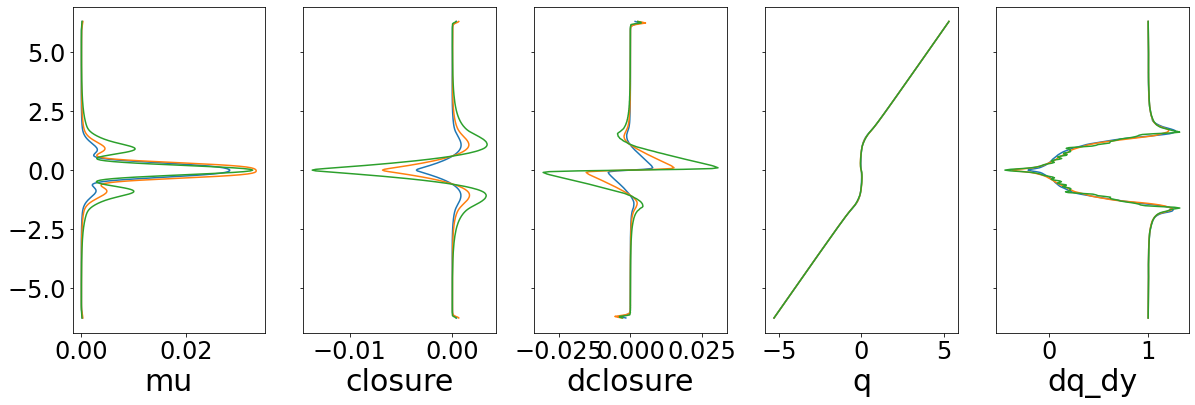

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(20,6))
for i in range(N_data):
    ax[0].plot(mu_f[i,:], yy)
    ax[1].plot(closure_mean[i,:], yy)
    ax[2].plot(d_closure_mean[i,:], yy)
    ax[3].plot(q_mean[i,:], yy)
    ax[4].plot(dq_dy_mean[i,:], yy)
    
    
    ax[0].set_xlabel("mu")
    ax[1].set_xlabel("closure")
    ax[2].set_xlabel("dclosure")
    ax[3].set_xlabel("q")
    ax[4].set_xlabel("dq_dy")


In [5]:
# Training nerual networks

In [8]:
layers = [4, 4, 4]
modes1 = [8, 8]
fc_dim = 4
activation = 'elu'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


for nn_save_name in ["diffusivity-fno.nn", "flux-fno.nn", "source-fno.nn"]:

    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity-fno.nn":        
        x_train =  np.stack((q_mean_abs, dq_dy_mean), axis=-1) 
        y_train =  mu_f[...,np.newaxis]/mu_scale
        in_dim = 2

    elif nn_save_name == "flux-fno.nn":
        x_train = np.stack((q_mean_abs, dq_dy_mean), axis=-1)
        y_train = closure_mean[...,np.newaxis]/flux_scale
        in_dim = 2
    elif nn_save_name == "source-fno.nn":
        x_train = np.stack((q_mean, dq_dy_mean), axis=-1)
        y_train = d_closure_mean[...,np.newaxis]/source_scale
        in_dim = 2
        
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")


    x_train = torch.from_numpy(x_train.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    ind = x_train.shape[1]
    outd = y_train.shape[1] 

    learning_rate = 0.001
    step_size = 100
    gamma = 0.5  
    epochs = 20000
    batch_size = 64

    net = NeuralNet.FNO1d(modes1=modes1, layers=layers,
                  fc_dim=fc_dim, in_dim=in_dim, out_dim=1, activation=activation).to(device)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    myloss = torch.nn.MSELoss(reduction='sum')
    t0 = default_timer()
    for ep in range(epochs):
        net.train()
        t1 = default_timer()
        train_l2 = 0
        for x, y in train_loader:

            optimizer.zero_grad()
            out = net(x)

            loss = myloss(out , y)*100
            loss.backward()

            optimizer.step()
            train_l2 += loss.item()


        if ep % 1000 == 0:
            # train_l2/= ntrain
            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
            if nn_save_name is not None:
                torch.save(net, nn_save_name)



start train nn :  diffusivity-fno.nn
Epoch :  0  Epoch time :  0.005567816086113453  Train L2 Loss :  2286.64697265625
Epoch :  1000  Epoch time :  0.0038461247459053993  Train L2 Loss :  97.36480712890625
Epoch :  2000  Epoch time :  0.0038199294358491898  Train L2 Loss :  48.00031661987305
Epoch :  3000  Epoch time :  0.003895780071616173  Train L2 Loss :  32.416194915771484
Epoch :  4000  Epoch time :  0.003847864456474781  Train L2 Loss :  17.770402908325195
Epoch :  5000  Epoch time :  0.0038485508412122726  Train L2 Loss :  12.967888832092285
Epoch :  6000  Epoch time :  0.0038493312895298004  Train L2 Loss :  11.241310119628906
Epoch :  7000  Epoch time :  0.003852664493024349  Train L2 Loss :  10.111915588378906
Epoch :  8000  Epoch time :  0.0038354918360710144  Train L2 Loss :  9.635169982910156
Epoch :  9000  Epoch time :  0.003854271024465561  Train L2 Loss :  8.637748718261719
Epoch :  10000  Epoch time :  0.0038578063249588013  Train L2 Loss :  7.890120029449463
Epoch :  

# Direct Test

start train nn :  diffusivity.nn
start train nn :  flux.nn
start train nn :  source.nn


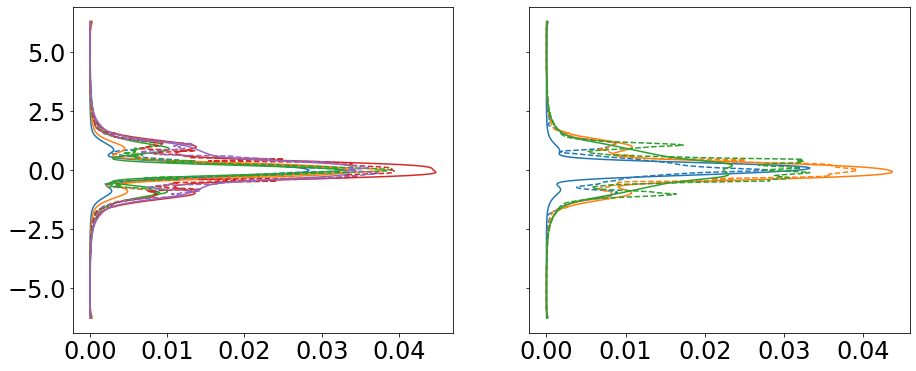

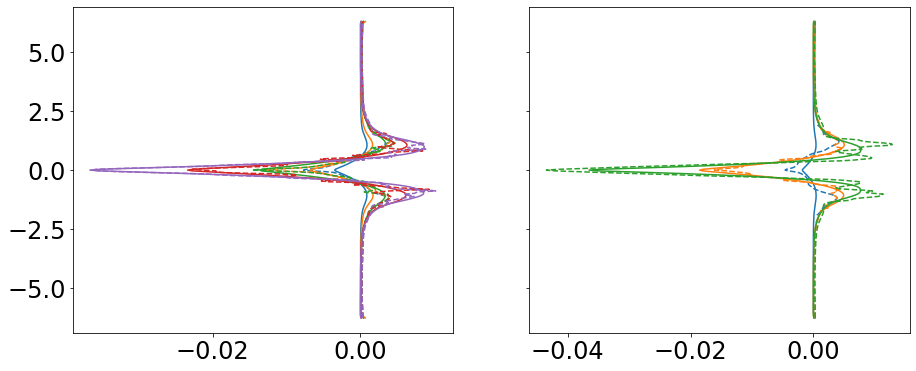

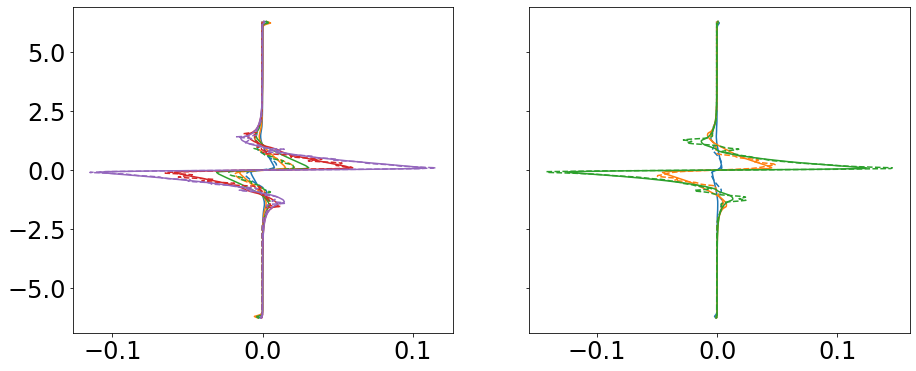

In [17]:
for nn_save_name in ["diffusivity.nn", "flux.nn", "source.nn"]:
    trained_net = torch.load(nn_save_name)
    
    print("start train nn : ", nn_save_name)
    if nn_save_name == "diffusivity.nn":        
        x_train  =  np.stack((q_mean_abs, dq_dy_mean), axis=-1)
        y_train_raw =  mu_f
        y_train   =  mu_f[...,np.newaxis]/mu_scale
        
        x_test  =  np.stack((q_mean_abs_test, dq_dy_mean_test), axis=-1)
        y_test_raw =  mu_f_test
        y_test   =  mu_f_test[...,np.newaxis]/mu_scale
        
        scale = mu_scale
        non_negative = True
    elif nn_save_name == "flux.nn":
        x_train = np.stack((q_mean_abs, dq_dy_mean), axis=-1)
        y_train_raw = closure_mean
        y_train = closure_mean[...,np.newaxis]/flux_scale
        
        x_test = np.stack((q_mean_abs_test, dq_dy_mean_test), axis=-1)
        y_test_raw = closure_mean_test
        y_test = closure_mean_test[...,np.newaxis]/flux_scale
        
        
        scale = flux_scale
        non_negative = False
    elif nn_save_name == "source.nn":
        x_train = np.stack((q_mean, dq_dy_mean), axis=-1)
        y_train_raw = d_closure_mean
        y_train = d_closure_mean[...,np.newaxis]/source_scale
        
        x_test = np.stack((q_mean_test, dq_dy_mean_test), axis=-1)
        y_test_raw = d_closure_mean_test
        y_test = d_closure_mean_test[...,np.newaxis]/source_scale
        
        
        scale = source_scale
        non_negative = False
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
    
    fig, ax = plt.subplots(ncols=2, sharey=True, nrows=1, figsize=((15,6)))
    
    N_data = q_mean_abs.shape[0]  
    y_train_pred = NeuralNet.net_eval(net=trained_net, x=x_train, mu_scale=scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))
    for i in range(N_data):
        ax[0].plot(y_train_raw[i,:], yy, color="C"+str(i))
        ax[0].plot(y_train_pred[i,:], yy, "--", color="C"+str(i))
    

    N_data = q_mean_abs_test.shape[0]  
    y_test_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_data).reshape((N_data, N_y))
    for i in range(N_data):
        ax[1].plot(y_test_raw[i,:], yy, color="C"+str(i))
        ax[1].plot(y_test_pred[i,:], yy, "--", color="C"+str(i))
    
    
#         ax[0].set_xlabel("closure")
#         ax[1].set_xlabel("mu")
    
    
    



In [11]:
# Plug-in Test

In [12]:
beta = 1.0
def point_jet(tau_inv, nn_save_name):
    trained_net = torch.load(nn_save_name)
    
    print("start ", tau_inv)

    Nx = 384
    omega_jet = np.zeros(Nx)
    omega_jet[0:Nx//2] = 1.0
    omega_jet[Nx//2:Nx] = -1.0
    L = 4*np.pi
    yy = np.linspace(-L/2.0, L/2.0, Nx)
    q_jet = omega_jet + beta*yy

    tau = 1/float(tau_inv)

    if nn_save_name  == "diffusivity.nn":
        nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=True, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
    elif nn_save_name  == "flux.nn":
        nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
    elif nn_save_name  == "source.nn":
        nn_model = partial(NeuralNet.fno_viscosity, net=trained_net, mu_scale = source_scale, non_negative=False, filter_on=filter_on, filter_sigma=filter_sigma)
        model = lambda q, yy, res : nummodel_source(nn_model, q, yy, res)
    else:
        print("nn_save_name : ", nn_save_name, " is not recognized")
            
            

    dt, Nt, save_every = 1.0e-4, 200000, 1000
    yy, t_pred, q_pred = explicit_solve(model, q_jet, tau, dt, Nt, save_every, L = L)
    q_mean_pred = np.mean(q_pred[Nt//(2*save_every):, :], axis=0)
    
    
    return yy,  q_mean_pred, q_pred

    

start  0.005
start  0.06
start  0.2
start  0.005
start  0.06
start  0.2
start  0.005
start  0.06
start  0.2


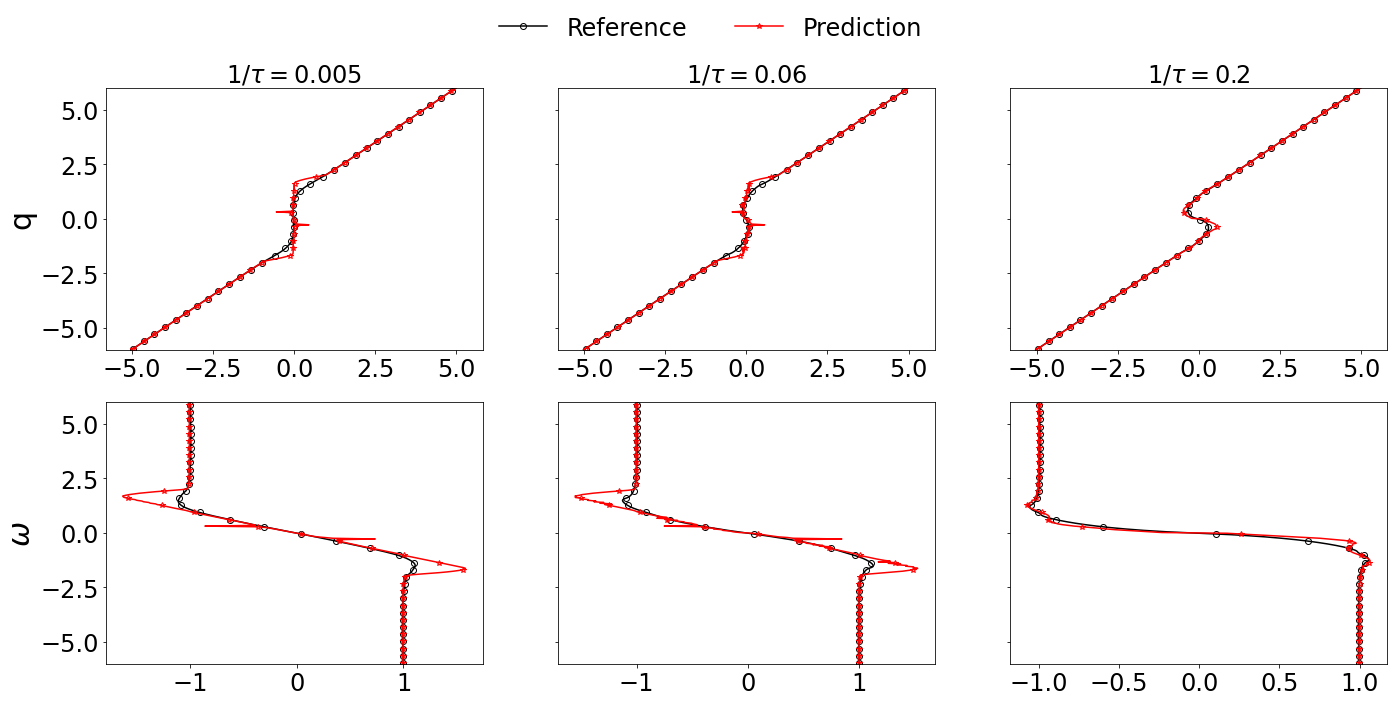

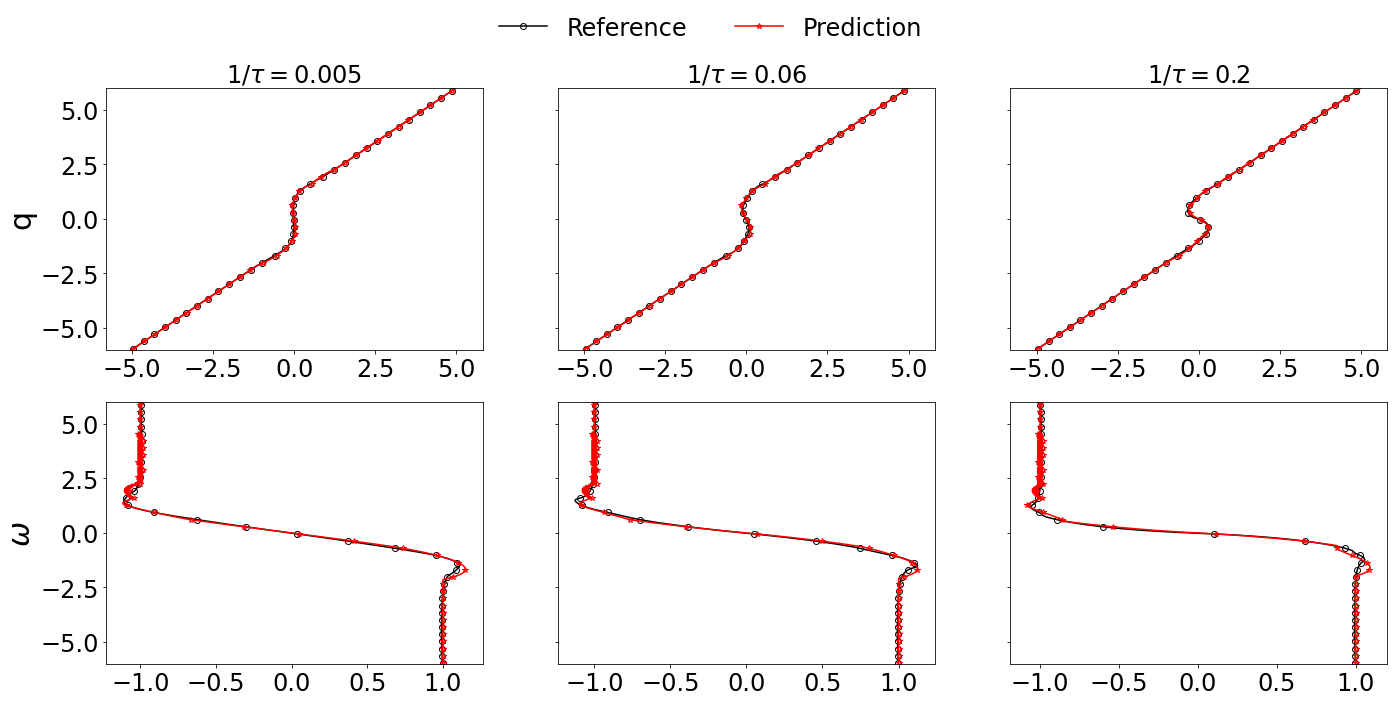

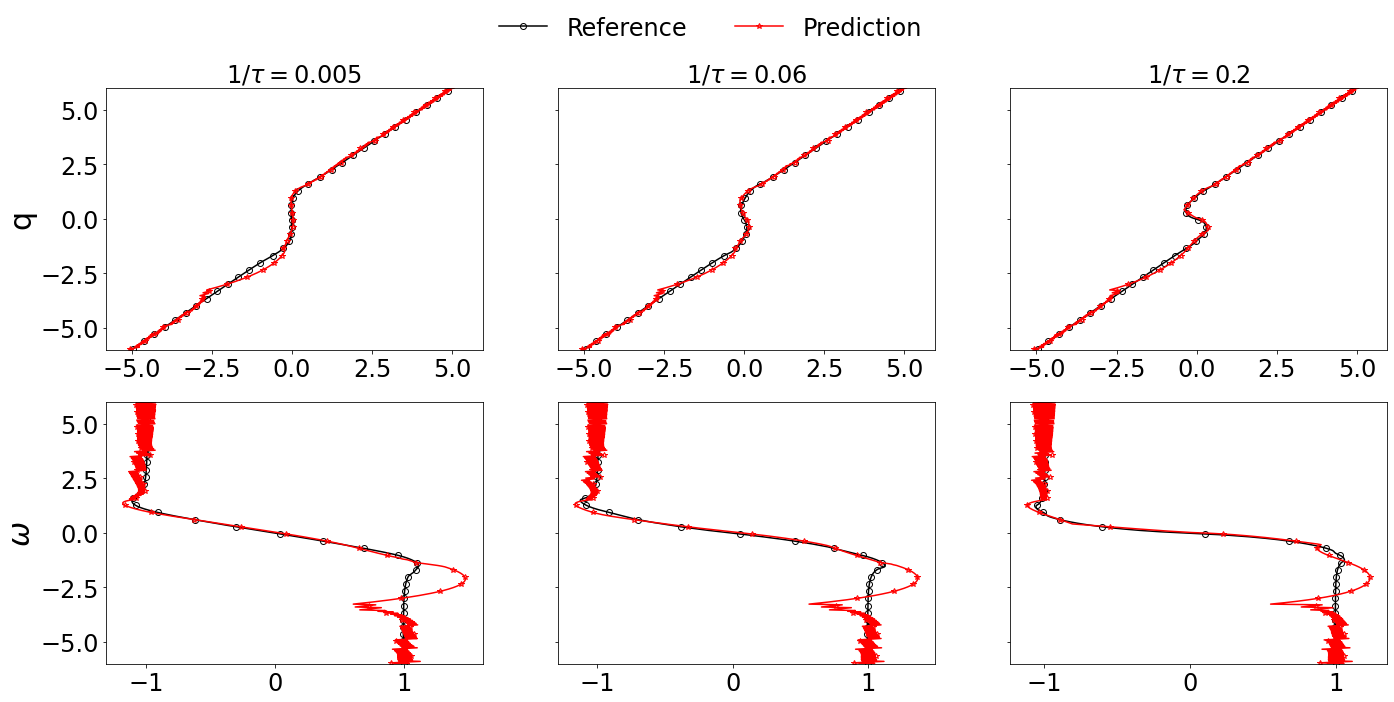

In [18]:
for nn_save_name in ["source.nn", "diffusivity.nn", "flux.nn"]:
    

    tau_invs = ["0.005", "0.06", "0.2"]
    q_mean_pred =  np.zeros((len(tau_invs), N_y))


    for i in range(len(tau_invs)):
        _, q_mean_pred[i,:], _ = point_jet(tau_invs[i], nn_save_name)



    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(20,10))
    markevery = 10

    omega_mean_test = np.copy(q_mean_test)
    omega_mean_pred = np.copy(q_mean)

    for i in range(3):
        omega_mean_test[i,:] = q_mean_test[i,:] - beta*yy
        omega_mean_pred[i,:] = q_mean_pred[i,:] - beta*yy

        color, marker, label = "black", "o", "Reference"
        ax[0, i].plot(q_mean_test[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
        ax[1, i].plot(omega_mean_test[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color)

        color, marker, label = "red", "*", "Prediction"
        ax[0, i].plot(q_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)
        ax[1, i].plot(omega_mean_pred[i,:], yy, "-", marker = marker, fillstyle = "none", markevery = markevery, color = color, label=label)


        ax[0, i].set_title(r"$1/\tau = $"+tau_invs[i])

    ax[0, 0].set_ylabel("q")
    ax[1, 0].set_ylabel(r"$\omega$")

    ax[0, 0].set_ylim([-6.0,6.0])
    ax[1, 0].set_ylim([-6.0,6.0])

    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.subplots_adjust(bottom=0.05,top=0.85,left=0.08,right=0.97)
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)
